In [1]:
import tensorflow

In [2]:
import keras

In [3]:
tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [4]:
import tensorflow_text

In [5]:
tensorflow.__version__

'2.8.0'

In [6]:
import tensorflow_text

In [7]:
tensorflow_text.__version__

'2.8.2'

In [8]:
tensorflow.__version__

'2.8.0'

In [9]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text 

In [10]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings


In [11]:
import os
import pandas as pd
import yaml
from dataset import DataLoader
from dataset import DataPreprocessing
from dataset import TokenizerWrap

In [12]:
def config_loader(filepath):
    with open (filepath, 'r') as file_descriptor:
        config = yaml.safe_load(file_descriptor)
    return config

In [13]:
config = config_loader('config/en_de.yaml')

In [14]:
lang_src, lang_dest = config['language']['src'],config['language']['dest'] 

In [15]:
path = 'training'
os.listdir(path)

['europarl-v7.es-en.en',
 'europarl-v7.es-en.es',
 'europarl-v7.de-en.en',
 'europarl-v7.cs-en.en',
 'questions_easy.csv',
 'europarl-v7.fr-en.fr',
 'europarl-v7.fr-en.en',
 'europarl-v7.de-en.de',
 'europarl-v7.cs-en.cs']

In [16]:
data_loader = DataLoader(config)

In [17]:
src, dest = data_loader.loadData(path)

Loaded dataset at directory:
training/europarl-v7.de-en.en


In [18]:
src_train = tf.convert_to_tensor(src[50000:150000])
dest_train = tf.convert_to_tensor(dest[50000:15000])

In [19]:
src_val = tf.convert_to_tensor(src[50001:60001])
dest_val = tf.convert_to_tensor(dest[50001:60001])

In [20]:
data_preprocessing = DataPreprocessing(config)

In [21]:
train_set = data_preprocessing.createDataFrameSrcDest(src[50000:150000],dest[50000:150000])

In [22]:
test_set = data_preprocessing.createDataFrameSrcDest(src[50001:60001],dest[50001:60001])

In [23]:
test_set = test_set.astype(str)

In [24]:
test_set.head()

,en,de
0,"Furthermore, most of the amendments, which I a...","Die Mehrzahl der Änderungsanträge, denen ich n..."
1,That is an issue which I have referred to before.,Darauf bin ich bereits früher eingegangen.
2,I know it is a controversial issue and I look ...,"Ich weiß, daß in diesem Punkt Uneinigkeit herr..."
3,"In substance, therefore, the Commission and Pa...",Sowohl Kommission als auch Parlament haben ein...
4,I should like especially to thank Mrs Roth-Beh...,Vor allem möchte ich Frau Roth-Behrendt und He...


In [25]:
train_set.head()

,en,de
0,Due to this thorough preparation I am in a pos...,Dank dieser ausgezeichneten Vorarbeit bin ich ...
1,"Furthermore, most of the amendments, which I a...","Die Mehrzahl der Änderungsanträge, denen ich n..."
2,That is an issue which I have referred to before.,Darauf bin ich bereits früher eingegangen.
3,I know it is a controversial issue and I look ...,"Ich weiß, daß in diesem Punkt Uneinigkeit herr..."
4,"In substance, therefore, the Commission and Pa...",Sowohl Kommission als auch Parlament haben ein...


In [26]:
src_set = tf.data.Dataset.from_tensor_slices(test_set['de'])
dest_set = tf.data.Dataset.from_tensor_slices(test_set['en'])
testing_set = tf.data.Dataset.zip((src_set,dest_set))

In [27]:
src_set = tf.data.Dataset.from_tensor_slices(train_set['de'])
dest_set = tf.data.Dataset.from_tensor_slices(train_set['en'])
training_set = tf.data.Dataset.zip((src_set,dest_set))

In [28]:
for de, en in training_set.take(5):
    print("English: ", en.numpy().decode('utf-8'))
    print()
    print("German:   ", de.numpy().decode('utf-8'))
    print()

English:  Due to this thorough preparation I am in a position today to agree in full or in part to almost three-quarters of your proposed amendments.

German:    Dank dieser ausgezeichneten Vorarbeit bin ich heute in der Lage, fast drei Viertel der von Ihnen vorgeschlagenen Änderungsanträge ganz oder teilweise zu akzeptieren.

English:  Furthermore, most of the amendments, which I am not in a position to accept, relate to two issues: the so-called "whereas" clauses - that is the recitals - and whether or not changes to certain provisions of the regulation should be by commitology or codecision.

German:    Die Mehrzahl der Änderungsanträge, denen ich nicht zustimmen kann, bezieht sich entweder auf die Erwägungen oder aber darauf, ob bestimmte Bestimmungen der Verordnung im Ausschußverfahren oder im Mitentscheidungsverfahren geändert werden sollten.

English:  That is an issue which I have referred to before.

German:    Darauf bin ich bereits früher eingegangen.

English:  I know it is

In [29]:
train_en = training_set.map(lambda de, en: en)
train_de = testing_set.map(lambda de, en: de)

In [30]:
tokenizers = tf.saved_model.load('translator_en_de_converter')

In [31]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [32]:
examples = []
for de, en in training_set.take(5):
    examples.append(en)

In [33]:
examples

[<tf.Tensor: shape=(), dtype=string, numpy=b'Due to this thorough preparation I am in a position today to agree in full or in part to almost three-quarters of your proposed amendments.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Furthermore, most of the amendments, which I am not in a position to accept, relate to two issues: the so-called "whereas" clauses - that is the recitals - and whether or not changes to certain provisions of the regulation should be by commitology or codecision.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'That is an issue which I have referred to before.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'I know it is a controversial issue and I look forward to discussing this particular issue in the Committee on Agriculture and Rural Development which is scheduled for July.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'In substance, therefore, the Commission and Parliament are equally committed to a strong regulation which puts in place a comprehensive f

In [34]:
encoded = tokenizers.en.tokenize(examples)

for row in encoded.to_list():
    print(row)

[2, 627, 66, 72, 2504, 2327, 40, 147, 68, 32, 264, 213, 66, 371, 68, 489, 108, 68, 238, 66, 1020, 419, 14, 4134, 65, 231, 331, 212, 15, 3]
[2, 805, 13, 205, 65, 64, 212, 13, 77, 40, 147, 80, 68, 32, 264, 66, 493, 13, 2660, 66, 215, 314, 27, 64, 121, 14, 608, 5, 2592, 5, 5334, 14, 70, 69, 64, 6294, 14, 67, 308, 108, 80, 675, 66, 293, 693, 65, 64, 304, 93, 75, 84, 2895, 5272, 108, 1787, 15, 3]
[2, 70, 69, 91, 187, 77, 40, 81, 959, 66, 296, 15, 3]
[2, 40, 239, 76, 69, 32, 3173, 187, 67, 40, 503, 431, 66, 1147, 72, 271, 187, 68, 64, 148, 74, 568, 67, 575, 171, 77, 69, 3325, 73, 2617, 15, 3]
[2, 68, 1856, 13, 142, 13, 64, 87, 67, 103, 78, 1942, 1189, 66, 32, 867, 304, 77, 3024, 68, 274, 32, 1305, 359, 66, 1710, 4837, 15, 3]


In [35]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'due', b'to', b'this', b'thorough', b'preparation', b'i',
  b'am', b'in', b'a', b'position', b'today', b'to', b'agree', b'in',
  b'full', b'or', b'in', b'part', b'to', b'almost', b'three', b'-',
  b'quarters', b'of', b'your', b'proposed', b'amendments', b'.', b'[END]'],
 [b'[START]', b'furthermore', b',', b'most', b'of', b'the', b'amendments',
  b',', b'which', b'i', b'am', b'not', b'in', b'a', b'position', b'to',
  b'accept', b',', b'relate', b'to', b'two', b'issues', b':', b'the', b'so',
  b'-', b'called', b'"', b'whereas', b'"', b'clauses', b'-', b'that', b'is',
  b'the', b'recitals', b'-', b'and', b'whether', b'or', b'not', b'changes',
  b'to', b'certain', b'provisions', b'of', b'the', b'regulation', b'should',
  b'be', b'by', b'commit', b'##ology', b'or', b'codecision', b'.', b'[END]'],
 [b'[START]', b'that', b'is', b'an', b'issue', b'which', b'i', b'have',
  b'referred', b'to', b'before', b'.', b'[END]']                       ,
 [b'[START]', b'i', 

In [36]:
lengths = []
for pt_examples, en_examples in training_set.batch(1024):
    pt_tokens = tokenizers.en.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

..................................................................................................

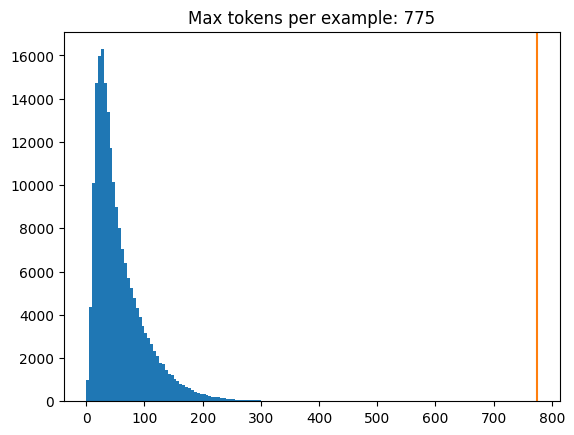

In [37]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');
plt.show()

In [38]:
MAX_TOKENS = 300

In [39]:
def filter_max_tokens(pt, en):
    num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
    return num_tokens < MAX_TOKENS

In [40]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [41]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [42]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(training_set)
val_batches = make_batches(testing_set)

In [43]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [44]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


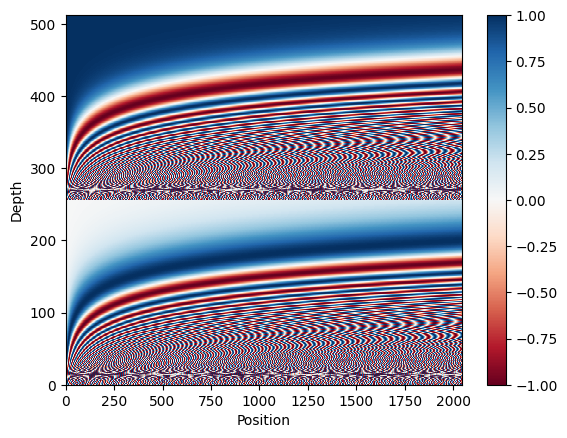

In [45]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [46]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [47]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [48]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [49]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [50]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [51]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [52]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [53]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [54]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [55]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [56]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [57]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [58]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [59]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [60]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [61]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [62]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [63]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [64]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [65]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [66]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [67]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [68]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [69]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [70]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [71]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [72]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

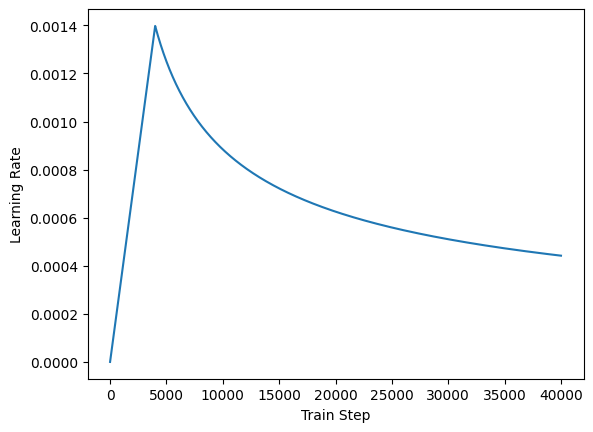

In [73]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [74]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [75]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [76]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [77]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

In [78]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [79]:
EPOCHS = 30

In [80]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 1.9018 Accuracy 0.6091
Epoch 1 Batch 50 Loss 1.9171 Accuracy 0.5924
Epoch 1 Batch 100 Loss 1.9518 Accuracy 0.5867
Epoch 1 Batch 150 Loss 1.9610 Accuracy 0.5849
Epoch 1 Batch 200 Loss 1.9604 Accuracy 0.5848
Epoch 1 Batch 250 Loss 1.9595 Accuracy 0.5845
Epoch 1 Batch 300 Loss 1.9615 Accuracy 0.5842
Epoch 1 Batch 350 Loss 1.9656 Accuracy 0.5835
Epoch 1 Batch 400 Loss 1.9733 Accuracy 0.5822
Epoch 1 Batch 450 Loss 1.9789 Accuracy 0.5811
Epoch 1 Batch 500 Loss 1.9825 Accuracy 0.5807
Epoch 1 Batch 550 Loss 1.9875 Accuracy 0.5800
Epoch 1 Batch 600 Loss 1.9907 Accuracy 0.5795
Epoch 1 Batch 650 Loss 1.9928 Accuracy 0.5791
Epoch 1 Batch 700 Loss 1.9951 Accuracy 0.5787
Epoch 1 Batch 750 Loss 1.9964 Accuracy 0.5785
Epoch 1 Batch 800 Loss 1.9977 Accuracy 0.5784
Epoch 1 Batch 850 Loss 1.9984 Accuracy 0.5782
Epoch 1 Batch 900 Loss 1.9992 Accuracy 0.5782
Epoch 1 Batch 950 Loss 1.9986 Accuracy 0.5782
Epoch 1 Batch 1000 Loss 1.9968 Accuracy 0.5786
Epoch 1 Batch 1050 Loss 1.9972 Accur

Epoch 6 Batch 400 Loss 1.9512 Accuracy 0.5851
Epoch 6 Batch 450 Loss 1.9541 Accuracy 0.5848
Epoch 6 Batch 500 Loss 1.9586 Accuracy 0.5840
Epoch 6 Batch 550 Loss 1.9614 Accuracy 0.5836
Epoch 6 Batch 600 Loss 1.9638 Accuracy 0.5832
Epoch 6 Batch 650 Loss 1.9675 Accuracy 0.5824
Epoch 6 Batch 700 Loss 1.9699 Accuracy 0.5819
Epoch 6 Batch 750 Loss 1.9693 Accuracy 0.5821
Epoch 6 Batch 800 Loss 1.9701 Accuracy 0.5821
Epoch 6 Batch 850 Loss 1.9700 Accuracy 0.5821
Epoch 6 Batch 900 Loss 1.9708 Accuracy 0.5821
Epoch 6 Batch 950 Loss 1.9685 Accuracy 0.5825
Epoch 6 Batch 1000 Loss 1.9673 Accuracy 0.5828
Epoch 6 Batch 1050 Loss 1.9676 Accuracy 0.5828
Epoch 6 Batch 1100 Loss 1.9663 Accuracy 0.5831
Epoch 6 Batch 1150 Loss 1.9658 Accuracy 0.5831
Epoch 6 Batch 1200 Loss 1.9653 Accuracy 0.5833
Epoch 6 Batch 1250 Loss 1.9670 Accuracy 0.5830
Epoch 6 Batch 1300 Loss 1.9656 Accuracy 0.5833
Epoch 6 Batch 1350 Loss 1.9650 Accuracy 0.5835
Epoch 6 Batch 1400 Loss 1.9651 Accuracy 0.5835
Epoch 6 Batch 1450 Loss 1

Epoch 11 Batch 750 Loss 1.9460 Accuracy 0.5859
Epoch 11 Batch 800 Loss 1.9458 Accuracy 0.5860
Epoch 11 Batch 850 Loss 1.9453 Accuracy 0.5861
Epoch 11 Batch 900 Loss 1.9455 Accuracy 0.5860
Epoch 11 Batch 950 Loss 1.9433 Accuracy 0.5864
Epoch 11 Batch 1000 Loss 1.9413 Accuracy 0.5867
Epoch 11 Batch 1050 Loss 1.9394 Accuracy 0.5871
Epoch 11 Batch 1100 Loss 1.9373 Accuracy 0.5874
Epoch 11 Batch 1150 Loss 1.9357 Accuracy 0.5877
Epoch 11 Batch 1200 Loss 1.9352 Accuracy 0.5879
Epoch 11 Batch 1250 Loss 1.9350 Accuracy 0.5879
Epoch 11 Batch 1300 Loss 1.9355 Accuracy 0.5878
Epoch 11 Batch 1350 Loss 1.9359 Accuracy 0.5878
Epoch 11 Batch 1400 Loss 1.9359 Accuracy 0.5878
Epoch 11 Batch 1450 Loss 1.9354 Accuracy 0.5880
Epoch 11 Batch 1500 Loss 1.9353 Accuracy 0.5881
Epoch 11 Batch 1550 Loss 1.9351 Accuracy 0.5881
Epoch 11 Loss 1.9347 Accuracy 0.5882
Time taken for 1 epoch: 256.25 secs

Epoch 12 Batch 0 Loss 1.6751 Accuracy 0.6291
Epoch 12 Batch 50 Loss 1.9069 Accuracy 0.5910
Epoch 12 Batch 100 Loss 

Epoch 16 Batch 1000 Loss 1.9183 Accuracy 0.5901
Epoch 16 Batch 1050 Loss 1.9179 Accuracy 0.5903
Epoch 16 Batch 1100 Loss 1.9161 Accuracy 0.5906
Epoch 16 Batch 1150 Loss 1.9148 Accuracy 0.5908
Epoch 16 Batch 1200 Loss 1.9148 Accuracy 0.5907
Epoch 16 Batch 1250 Loss 1.9147 Accuracy 0.5908
Epoch 16 Batch 1300 Loss 1.9147 Accuracy 0.5908
Epoch 16 Batch 1350 Loss 1.9147 Accuracy 0.5909
Epoch 16 Batch 1400 Loss 1.9139 Accuracy 0.5911
Epoch 16 Batch 1450 Loss 1.9130 Accuracy 0.5913
Epoch 16 Batch 1500 Loss 1.9125 Accuracy 0.5914
Epoch 16 Batch 1550 Loss 1.9122 Accuracy 0.5915
Epoch 16 Loss 1.9125 Accuracy 0.5914
Time taken for 1 epoch: 257.42 secs

Epoch 17 Batch 0 Loss 1.8369 Accuracy 0.6055
Epoch 17 Batch 50 Loss 1.8885 Accuracy 0.5946
Epoch 17 Batch 100 Loss 1.8941 Accuracy 0.5940
Epoch 17 Batch 150 Loss 1.8918 Accuracy 0.5944
Epoch 17 Batch 200 Loss 1.8929 Accuracy 0.5947
Epoch 17 Batch 250 Loss 1.8921 Accuracy 0.5949
Epoch 17 Batch 300 Loss 1.8906 Accuracy 0.5952
Epoch 17 Batch 350 Loss 

Epoch 21 Batch 1250 Loss 1.8967 Accuracy 0.5938
Epoch 21 Batch 1300 Loss 1.8951 Accuracy 0.5942
Epoch 21 Batch 1350 Loss 1.8946 Accuracy 0.5943
Epoch 21 Batch 1400 Loss 1.8941 Accuracy 0.5944
Epoch 21 Batch 1450 Loss 1.8942 Accuracy 0.5944
Epoch 21 Batch 1500 Loss 1.8940 Accuracy 0.5945
Epoch 21 Batch 1550 Loss 1.8937 Accuracy 0.5946
Epoch 21 Loss 1.8936 Accuracy 0.5947
Time taken for 1 epoch: 260.60 secs

Epoch 22 Batch 0 Loss 1.9384 Accuracy 0.5808
Epoch 22 Batch 50 Loss 1.8887 Accuracy 0.5956
Epoch 22 Batch 100 Loss 1.8839 Accuracy 0.5957
Epoch 22 Batch 150 Loss 1.8773 Accuracy 0.5964
Epoch 22 Batch 200 Loss 1.8788 Accuracy 0.5962
Epoch 22 Batch 250 Loss 1.8748 Accuracy 0.5972
Epoch 22 Batch 300 Loss 1.8745 Accuracy 0.5975
Epoch 22 Batch 350 Loss 1.8788 Accuracy 0.5970
Epoch 22 Batch 400 Loss 1.8846 Accuracy 0.5958
Epoch 22 Batch 450 Loss 1.8874 Accuracy 0.5954
Epoch 22 Batch 500 Loss 1.8918 Accuracy 0.5945
Epoch 22 Batch 550 Loss 1.8922 Accuracy 0.5945
Epoch 22 Batch 600 Loss 1.892

Epoch 26 Batch 1500 Loss 1.8767 Accuracy 0.5973
Epoch 26 Batch 1550 Loss 1.8775 Accuracy 0.5972
Epoch 26 Loss 1.8773 Accuracy 0.5973
Time taken for 1 epoch: 265.43 secs

Epoch 27 Batch 0 Loss 1.8381 Accuracy 0.5953
Epoch 27 Batch 50 Loss 1.8557 Accuracy 0.6005
Epoch 27 Batch 100 Loss 1.8512 Accuracy 0.6005
Epoch 27 Batch 150 Loss 1.8497 Accuracy 0.6006
Epoch 27 Batch 200 Loss 1.8475 Accuracy 0.6012
Epoch 27 Batch 250 Loss 1.8470 Accuracy 0.6015
Epoch 27 Batch 300 Loss 1.8492 Accuracy 0.6011
Epoch 27 Batch 350 Loss 1.8543 Accuracy 0.6006
Epoch 27 Batch 400 Loss 1.8620 Accuracy 0.5995
Epoch 27 Batch 450 Loss 1.8672 Accuracy 0.5985
Epoch 27 Batch 500 Loss 1.8708 Accuracy 0.5978
Epoch 27 Batch 550 Loss 1.8740 Accuracy 0.5971
Epoch 27 Batch 600 Loss 1.8756 Accuracy 0.5969
Epoch 27 Batch 650 Loss 1.8771 Accuracy 0.5966
Epoch 27 Batch 700 Loss 1.8799 Accuracy 0.5960
Epoch 27 Batch 750 Loss 1.8802 Accuracy 0.5960
Epoch 27 Batch 800 Loss 1.8807 Accuracy 0.5959
Epoch 27 Batch 850 Loss 1.8812 Acc

In [82]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is english, initialize the output with the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [83]:
translator = Translator(tokenizers, transformer)

In [84]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [85]:
sentence = 'Ich möchte der Europäischen Union beitreten.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Ich möchte der Europäischen Union beitreten.
Prediction     : i want to join the european union .
Ground truth   : this is a problem we have to solve .


In [86]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [87]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 10])

In [88]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'ich', b'mochte', b'der', b'europaischen', b'union',
       b'bei', b'##treten', b'.', b'[END]'], dtype=object)>

In [89]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'i', b'want', b'to', b'join', b'the', b'european',
       b'union', b'.', b'[END]'], dtype=object)>

In [90]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [91]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

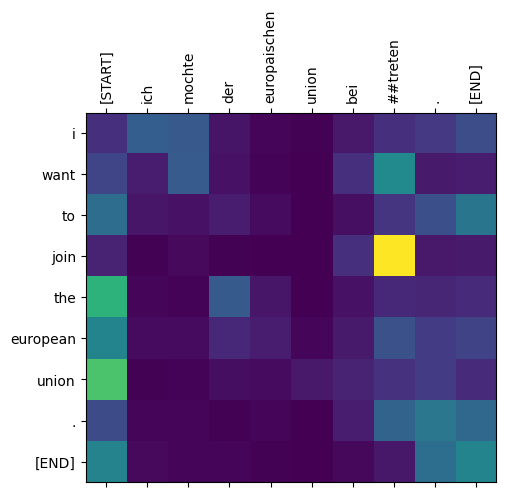

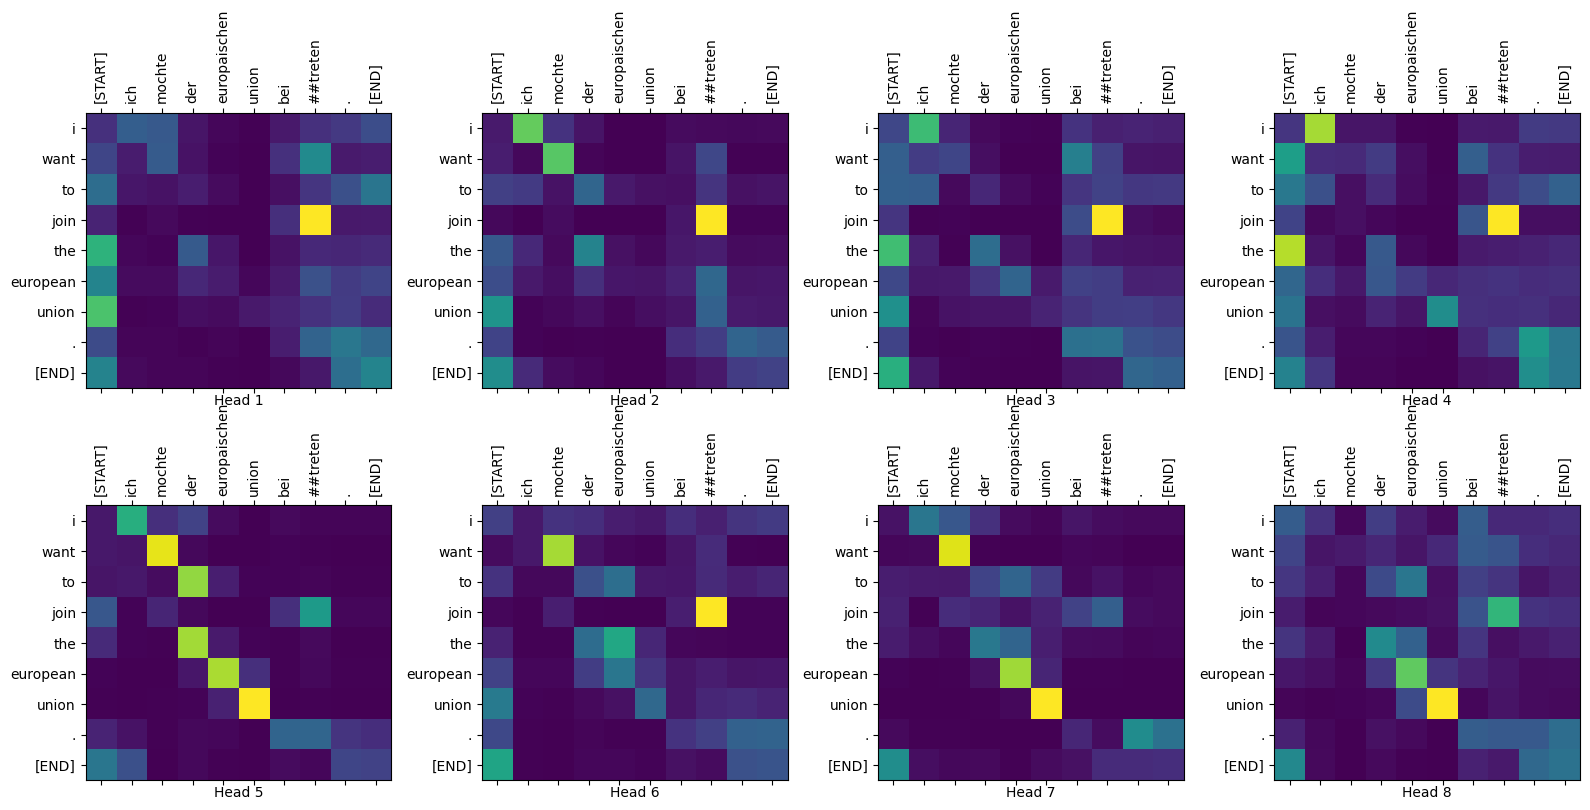

In [92]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Input:         : Ich lese gerne viele Bücher.
Prediction     : i would like to read a few visitors .
Ground truth   : I like to read many books


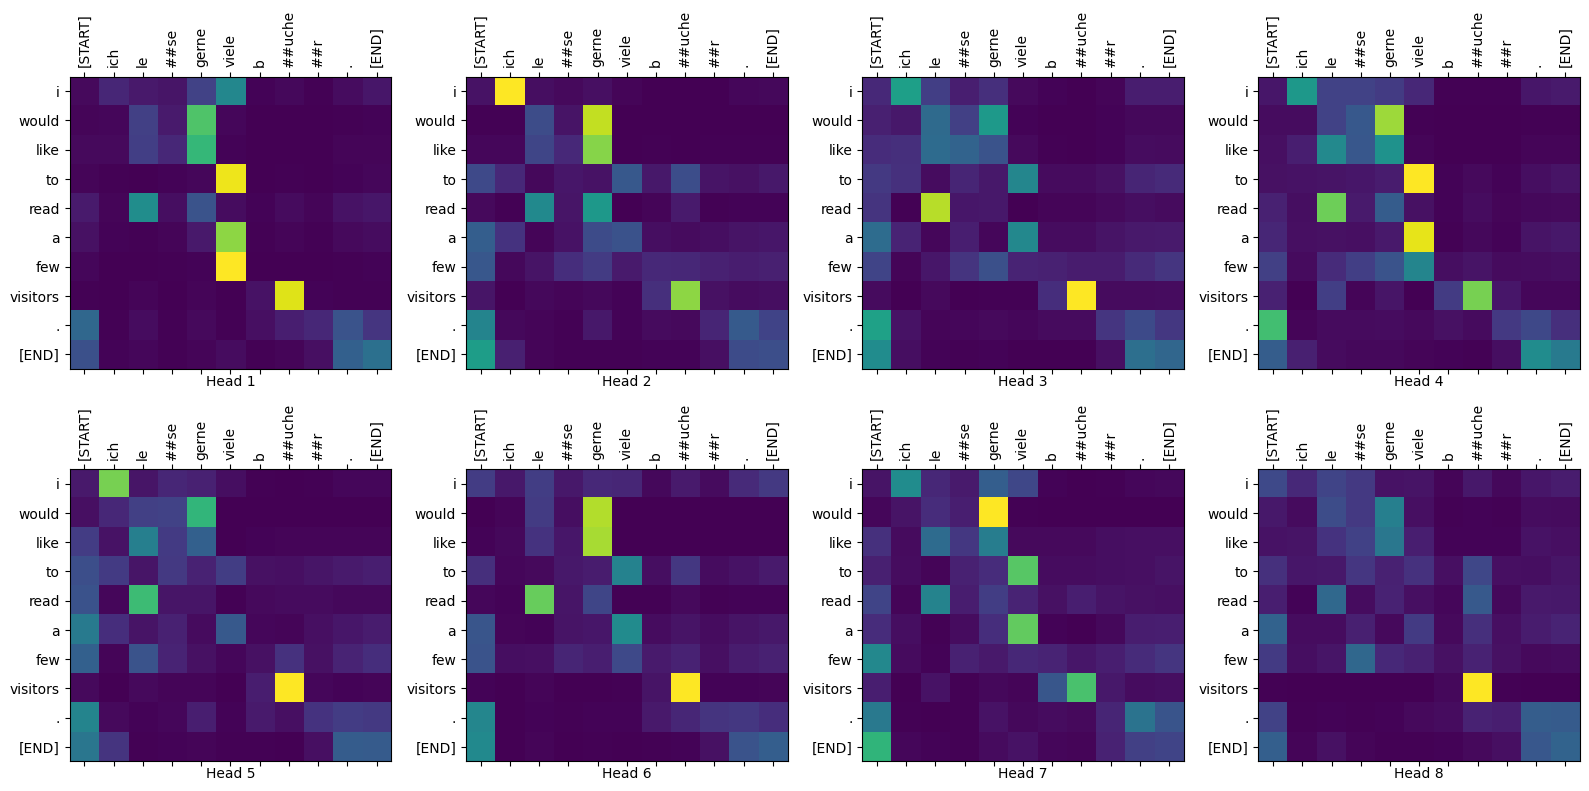

In [93]:
sentence = 'Ich lese gerne viele Bücher.'
ground_truth = 'I like to read many books'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Input:         : In den letzten zehn Jahren versuchte die Türkei, der Europäischen Union beizutreten, aber sie scheiterten.
Prediction     : in the last ten years , turkey tried to join the european union , but it failed to do so .
Ground truth   : 


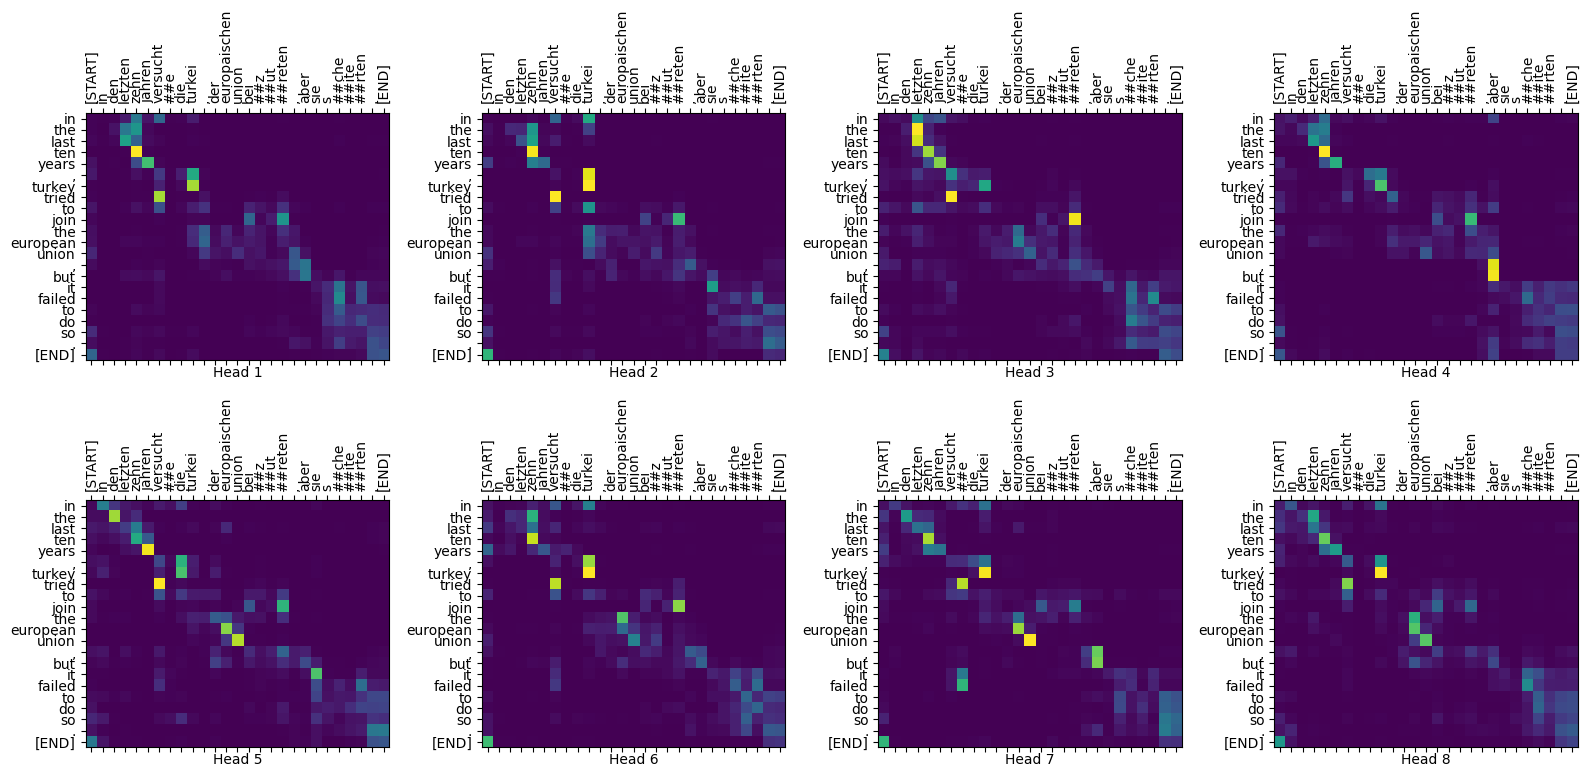

In [94]:
sentence = 'In den letzten zehn Jahren versuchte die Türkei, der Europäischen Union beizutreten, aber sie scheiterten.'
ground_truth = 'I like to read many books'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text,"")

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

In [98]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
scores = []
sum_scores = 0
cnt = 0
for i in range(1,50):
    sentence = dest[-i]
    ground_truth = src[-i]
    if(ground_truth=="" or sentence==""):
        print('skipped')
    translated_text, translated_tokens, attention_weights = translator(
        tf.constant(sentence))
    GT_token = word_tokenize(ground_truth)
    predicted_token = word_tokenize(translated_text.numpy().decode("utf-8"))
    #tokens.numpy().decode("utf-8")
    BLEUscore = sentence_bleu([GT_token], predicted_token)
    print_translation(sentence, translated_text,ground_truth)
    sum_scores= sum_scores + BLEUscore
    scores.append(BLEUscore)
    cnt = cnt + 1
    print("SCORE: " + str(BLEUscore))

skipped
Input:         : 
Prediction     : i would like to say that we are in favour of the report .
Ground truth   : 
SCORE: 0
Input:         : (Die Sitzung wird um 10.50 Uhr geschlossen.)
Prediction     : ( the sitting was closed at 10 . 50 p . m . )
Ground truth   : (The sitting was closed at 10.50 a.m.)
SCORE: 0.21972813874997157
Input:         : Ich erkläre die Sitzungsperiode des Europäischen Parlaments für unterbrochen.
Prediction     : i declare the session of the european parliament adjourned .
Ground truth   : I declare the session of the European Parliament adjourned.
SCORE: 0.4518010018049224


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Input:         : Unterbrechung der Sitzungsperiode
Prediction     : adjournment of the session
Ground truth   : Adjournment of the session
SCORE: 8.636168555094496e-78


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Input:         : Ich will die Aussprache über "Millennium ja, Millennium nein " nicht noch einmal eröffnen, aber ich möchte Ihnen allen und darüber hinaus den von uns vertretenen europäischen Bürgern ein glückliches Jahr 2000 wünschen.
Prediction     : i do not want to open the debate on " mildium , mild " , but i would like to see you all and all of us , as well as the european citizens , want to see a good year .
Ground truth   : I am not going to re-open the 'Millennium or not the Millennium' debate, but I am going to wish all of you, and by extension, all the citizens of Europe which we represent, a happy year 2000.
SCORE: 5.686415395601241e-155
Input:         : Ich möchte mir sogar erlauben, die Kommission und den Rat zu nennen, auch wenn sie nicht anwesend sind.
Prediction     : i would like to mention the commission and the council , even though they are not present .
Ground truth   : I would also like, although they are absent, to mention the Commission and the Council.
SCORE: 

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Input:         : Damit, meine Damen und Herren, hat das Parlament die Tagesordnung abgearbeitet.
Prediction     : this is the order of parliament , ladies and gentlemen , which has been drawn up .
Ground truth   : Having said that, Parliament has reached the end of the agenda.
SCORE: 1.3416480207402436e-231
Input:         : Herr Posselt, ich freue mich sehr. Aber auf jeden Fall erinnere ich Sie daran, daß man, um genau zu sein, auf den entsprechenden Artikel der Geschäftsordnung Bezug nehmen muß, wenn man um das Wort zu einer Geschäftsordnungsfrage bittet.
Prediction     : mr posselt , i am very pleased , but i would remind you that we must be very precise in the rules of procedure when you ask for a point of order .
Ground truth   : Mr Posselt, I am very pleased, but in any case, I would remind you that, when requesting a procedural motion, you actually have to indicate the Rule to which you are referring.
SCORE: 0.1747786616733348
Input:         : Ich wollte der Kommissarin eine Frag

Input:         : Ich habe während der Debatte geschaut, was hier genau über die Abstimmung zum Bericht Murphy über den Zahlungsrückstand aufgeschrieben wurde.
Prediction     : i have seen what was done here in the debate on the murphy report on the payment of payment appropriations .
Ground truth   : During the debate, I was watching what exactly was written down regarding the vote for the Murphy report on late payment.
SCORE: 6.335137024383434e-155
Input:         : Herr Präsident! Ganz kurz zu den gestern angenommenen Texten.
Prediction     : mr president , i would like to briefly address the texts adopted yesterday .
Ground truth   : Mr President, very briefly on a point of order regarding the texts adopted yesterday.
SCORE: 0.25068244494498715
Input:         : Ich möchte allen Kollegen recht herzlich danken, die mich hier unterstützt haben, möchte frohe Weihnachten wünschen und ein gutes Neues Jahr!
Prediction     : i would like to thank all my fellow members who have supported me h

Input:         : Für Armenien und Georgien ist die Zuschußkürzung der Gemeinschaft schwer einsehbar, da diese beiden Länder mit Hilfe des IWF und anderer Geber große Anstrengungen unternommen haben, um ihre finanziellen Verpflichtungen gegenüber der Gemeinschaft abzubauen.
Prediction     : for armenia and georgia , the community ' s average is difficult to reach a rapid reaction because these two countries have made a great effort to reduce their financial commitments towards the community and other donors .
Ground truth   : Armenia and Georgia will have difficulty understanding the fact that the Community is reducing its aid, in spite of the major efforts which these two countries, with support from the IMF and other contributors, have made to reduce their financial liabilities towards the Community.
SCORE: 0.09604924351440115
Input:         : Während der kommenden Jahre kann es jedoch zu einer weiteren Kürzung kommen, falls die Zuschüsse wie geplant gewährt werden.
Prediction     : h

In [101]:
!pip install rouge_score

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [102]:
from rouge_score import rouge_scorer

hyp = ['This is the first sample', 'This is another example']
# a list of the references documents
ref = ['This is the first sentence', 'It is one more sentence']

# make a RougeScorer object with rouge_types=['rouge1']
scorer = rouge_scorer.RougeScorer(['rouge1'])

# a dictionary that will contain the results
results = {'precision': [], 'recall': [], 'fmeasure': []}

In [104]:
for i in range(1,50):
    # computing the ROUGE
    
    # separating the measurements
    sentence = dest[-i]
    ground_truth = src[-i]
    if(ground_truth=="" or sentence==""):
        print('skipped')
    translated_text, translated_tokens, attention_weights = translator(
        tf.constant(sentence))
    score = scorer.score(translated_text.numpy(),ground_truth)
    precision, recall, fmeasure = score['rouge1']
    # add them to the proper list in the dictionary
    print_translation(sentence, translated_text,ground_truth)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['fmeasure'].append(fmeasure)
    print('precision: ' + str(precision))
    
    print('recall: ' + str(recall))
    
    print('fmeasure: ' + str(fmeasure))
    print('_______________')
    

skipped
Input:         : 
Prediction     : i would like to say that we are in favour of the report .
Ground truth   : 
precision: 0.0
recall: 0.0
fmeasure: 0.0
_______________
Input:         : (Die Sitzung wird um 10.50 Uhr geschlossen.)
Prediction     : ( the sitting was closed at 10 . 50 p . m . )
Ground truth   : (The sitting was closed at 10.50 a.m.)
precision: 0.8888888888888888
recall: 0.8888888888888888
fmeasure: 0.8888888888888888
_______________
Input:         : Ich erkläre die Sitzungsperiode des Europäischen Parlaments für unterbrochen.
Prediction     : i declare the session of the european parliament adjourned .
Ground truth   : I declare the session of the European Parliament adjourned.
precision: 1.0
recall: 1.0
fmeasure: 1.0
_______________
Input:         : Unterbrechung der Sitzungsperiode
Prediction     : adjournment of the session
Ground truth   : Adjournment of the session
precision: 1.0
recall: 1.0
fmeasure: 1.0
_______________
Input:         : Ich will die Aussprac

Input:         : Wie Sie richtig sagten, wurden Sie am 16. September gewählt, und dieser Bericht gibt den Stand vom 13. Juni wieder.
Prediction     : as you have said , you were elected on 16 september and this report is re - established by 13 june .
Ground truth   : You were elected on 16 September - as you quite rightly said - and this report concerns those who were elected on 13 June.
precision: 0.6363636363636364
recall: 0.7368421052631579
fmeasure: 0.6829268292682926
_______________
Input:         : Frau Lulling, ich kann das nicht korrigieren, denn dieser Bericht betrifft Sie gar nicht.
Prediction     : mrs lulling , i cannot correct this because this report does not affect it .
Ground truth   : Mrs Lulling, I cannot rectify this because this report does not affect you.
precision: 0.8461538461538461
recall: 0.8461538461538461
fmeasure: 0.8461538461538461
_______________
Input:         : Können Sie das bitte korrigieren?
Prediction     : can you please correct this ?
Ground truth 

Input:         : Wie Herr Blokland in seinen Ausführungen möchte ich der Kommissarin, Frau Wallström, - die den Rentnern in Italien, Griechenland und Spanien wegen Altautos, die schnell aus dem Verkehr gezogen werden sollen, schlaflose Nächte bereitet - sagen, daß ich es begrüßen würde, wenn die für Tadschikistan und andere Staaten bereitgestellten Hilfen auch im Hinblick auf ihren Verwendungszeck kontrolliert würden.
Prediction     : as mr blokland said in his speech , commissioner wallstrom , who are to be prepared to send the pensioners in italy , greece and spain to be prepared to pay for the traffic , i would like to say that if the aid provided for saddam and other states were monitored .
Ground truth   : I would like, as Mr Blokland said in his statement, to say to Commissioner Wallström - who is disturbing the sleep of Italian, Greek and Spanish pensioners because of superannuated cars which have to be quickly taken off the roads - that I would appreciate verification as to how

In [108]:
sentence = 'Die Aufgaben des Europäischen Parlaments sind in Art. 14 EU-Vertrag beschrieben. Demzufolge wird das Parlament gemeinsam mit dem Rat als Gesetzgeber tätig, übt gemeinsam mit ihm die Haushaltsbefugnisse aus und nimmt die politische Kontrolle wahr. Des Weiteren soll es beratend tätig werden und den Kommissionspräsidenten wählen.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text,"")



Input:         : Die Aufgaben des Europäischen Parlaments sind in Art. 14 EU-Vertrag beschrieben. Demzufolge wird das Parlament gemeinsam mit dem Rat als Gesetzgeber tätig, übt gemeinsam mit ihm die Haushaltsbefugnisse aus und nimmt die politische Kontrolle wahr. Des Weiteren soll es beratend tätig werden und den Kommissionspräsidenten wählen.
Prediction     : the european parliament ' s tasks are written in the form of 14 eu treaty , and parliament is working together with the council as legislators , with the budgetary powers and takes up political control , and the further debate will be carried out and the president of the commission will be involved .
Ground truth   : 


In [113]:
!pip install seaborn

     |████████████████████████████████| 292 kB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [115]:
import seaborn as sns

In [139]:
filtered = filter(lambda score: score > 0.1, scores)

In [140]:
filtered = list(filtered)

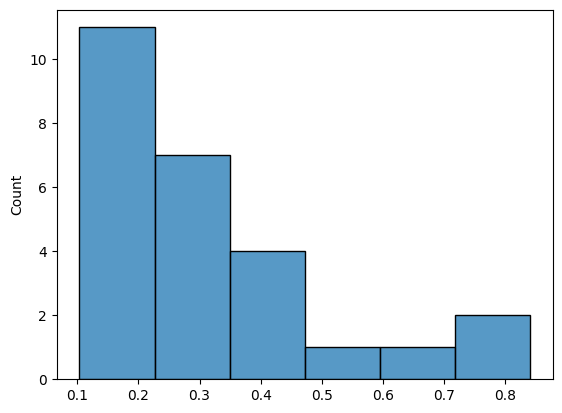

In [141]:
sns.histplot(data=filtered)
plt.show()

In [144]:
recall_filter=list(filter(lambda score: score > 0.1, results['recall']))
percesion_filter=  list(filter(lambda score: score > 0.1, results['precision']))
f1_filter = list(filter(lambda score: score > 0.1, results['fmeasure']))

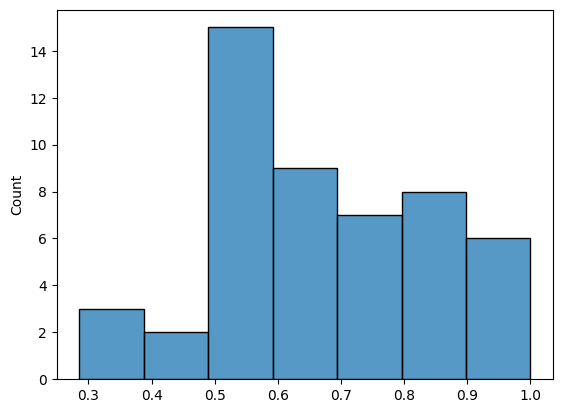

In [145]:
sns.histplot(data=recall_filter)
plt.show()

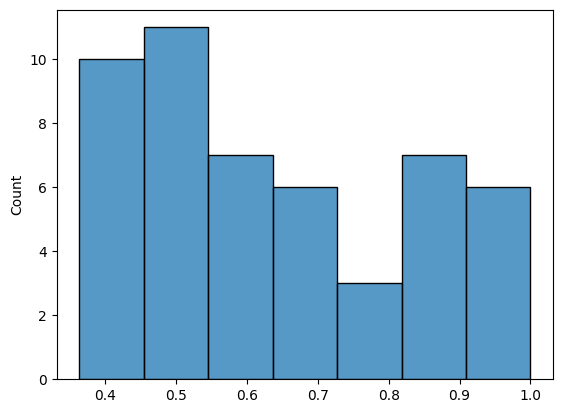

In [146]:
sns.histplot(data=percesion_filter)
plt.show()

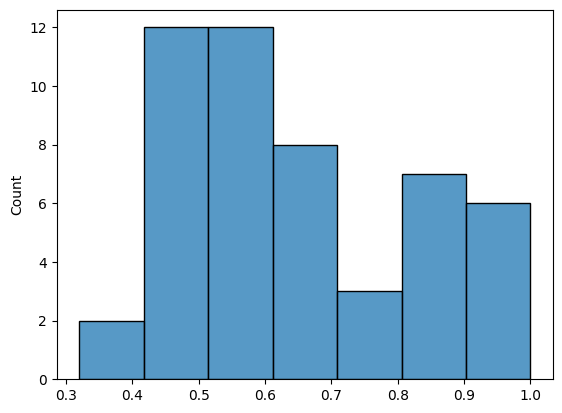

In [151]:
sns.histplot(data=f1_filter)
plt.show()